### Importing necessary library

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Data Pipeline Modularization

In [2]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, target_column):
    """Split dataset into X, y and perform scaling."""
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

def split_data(X, y, test_size=0.2, random_state=42):
    """Split dataset into train and test sets."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)


### Adding Data

In [3]:
df = pd.read_csv('ransomware_data.csv')

df_sample = df.sample(n=6000, random_state=28)
df_sample.to_csv('ransomware_data_sample.csv', index=False)

print("Sampled dataset shape:", df_sample.shape)
print("Sampled CSV saved as: ransomware_data_sample.csv")

Sampled dataset shape: (6000, 53)
Sampled CSV saved as: ransomware_data_sample.csv


### Checking missing value

In [4]:
missing_counts = df_sample.isnull().sum()
print("Missing values per column:\n", missing_counts)

Missing values per column:
 Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Length of Fwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd Header Length              0
Bwd Header Leng

### Duplicate row and dropping them

In [5]:
duplicates_count = df_sample.duplicated().sum()
if duplicates_count > 0:
    print(f"Number of duplicate rows: {duplicates_count}")
    df_sample.drop_duplicates(inplace=True)
    print("Duplicates dropped.")
else:
    print("No duplicate rows found.")


No duplicate rows found.


### Check unique labels first

In [6]:
print("Unique labels in Attack Type:", df_sample['Attack Type'].unique())

Unique labels in Attack Type: ['Normal Traffic' 'DoS' 'DDoS' 'Port Scanning' 'Brute Force' 'Web Attacks'
 'Bots']


### Encode using sklearn's LabelEncoder

In [7]:
encoder = LabelEncoder()
df_sample['Attack Type Enc'] = encoder.fit_transform(df_sample['Attack Type'])

### Show mapping

In [8]:
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'Bots': 0, 'Brute Force': 1, 'DDoS': 2, 'DoS': 3, 'Normal Traffic': 4, 'Port Scanning': 5, 'Web Attacks': 6}


### Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split
 
X = df_sample.drop(['Attack Type', 'Attack Type Enc'], axis=1)  
y = df_sample['Attack Type Enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

### StratifiedShuffleSplit

In [10]:
X_np = X.values
y_np = y.values

In [11]:
from sklearn.model_selection import StratifiedKFold
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
for train_index, test_index in sss.split(X_np, y_np):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Stratified train-test split completed.")


Stratified train-test split completed.


### Apply SMOTE only to the training set

In [14]:
sm = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, "Class distribution:", np.bincount(y_train))
print("After SMOTE: ", X_train_resampled.shape, "Class distribution:", np.bincount(y_train_resampled))

Before SMOTE: (4800, 52) Class distribution: [   3   16  238  387 3960  189    7]
After SMOTE:  (27720, 52) Class distribution: [3960 3960 3960 3960 3960 3960 3960]


### Transform both the TRAIN and TEST sets

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_resampled)

X_train_scaled = scaler.transform(X_train_resampled)
X_test_scaled  = scaler.transform(X_test)

### Quick check of a feature distribution before and after scaling

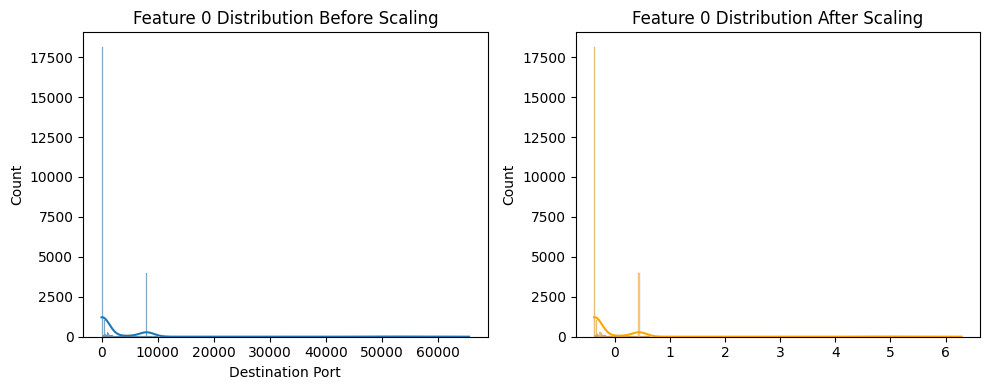

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(X_train_resampled.iloc[:, 0], kde=True)
plt.title("Feature 0 Distribution Before Scaling")

plt.subplot(1,2,2)
sns.histplot(X_train_scaled[:,0], kde=True, color='orange')
plt.title("Feature 0 Distribution After Scaling")

plt.tight_layout()
plt.show()

### create a series that counts the number of unique values in each column

In [17]:
unique_counts = df_sample.nunique()

near_constant_cols = unique_counts[unique_counts <= 1].index.tolist()

if near_constant_cols:
    print("Columns with only 1 unique value (or all zero):")
    print(near_constant_cols)
else:
    print("No columns with a single unique value found.")

No columns with a single unique value found.


### Select columns with correlation above a threshold 

In [18]:
corr_matrix = df_sample.corr(numeric_only=True).abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_threshold = 0.95
to_drop_corr = [
    column for column in upper.columns
    if any(upper[column] > high_corr_threshold)
]

print("Highly correlated columns (r > 0.95):", to_drop_corr)

Highly correlated columns (r > 0.95): ['Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Std', 'Average Packet Size', 'Subflow Fwd Bytes', 'Idle Mean', 'Idle Max', 'Idle Min']


In [19]:
df_sample.drop(columns=to_drop_corr, inplace=True)
print("Dropped highly correlated columns:", to_drop_corr)

Dropped highly correlated columns: ['Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Std', 'Average Packet Size', 'Subflow Fwd Bytes', 'Idle Mean', 'Idle Max', 'Idle Min']


### Changed from df_clean to df

In [20]:
df_sample = df.sample(frac=0.05, random_state=42)

In [21]:
feature_cols = [col for col in df_sample.columns   
                if col not in ['Attack Type', 'Attack Type Enc']]
target_col = 'Attack Type' 
X = df_sample[feature_cols] 
y = df_sample[target_col]   

### Train and Test set size

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,         
    random_state=42,       
    stratify=y              
)

print("Training set size:", X_train.shape,
      "Class distribution:", y_train.value_counts().to_dict())
print("Test set size:    ", X_test.shape,
      "Class distribution:", y_test.value_counts().to_dict())


Training set size: (100830, 52) Class distribution: {'Normal Traffic': 83771, 'DoS': 7736, 'DDoS': 5154, 'Port Scanning': 3617, 'Brute Force': 382, 'Web Attacks': 88, 'Bots': 82}
Test set size:     (25208, 52) Class distribution: {'Normal Traffic': 20943, 'DoS': 1934, 'DDoS': 1289, 'Port Scanning': 905, 'Brute Force': 95, 'Web Attacks': 22, 'Bots': 20}


### Before SMOTE and after SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())

Before SMOTE:
Attack Type
Normal Traffic    83771
DoS                7736
DDoS               5154
Port Scanning      3617
Brute Force         382
Web Attacks          88
Bots                 82
Name: count, dtype: int64

After SMOTE:
Attack Type
Normal Traffic    83771
DoS               83771
DDoS              83771
Port Scanning     83771
Brute Force       83771
Web Attacks       83771
Bots              83771
Name: count, dtype: int64


### Fit on training set only (to avoid data leakage)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train_res)

# Transform both training and test sets
X_train_scaled = scaler.transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

### Initialize the model

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  
)

# Train on the SMOTE-resampled + scaled training data
rf_clf.fit(X_train_scaled, y_train_res)

# Predict on the scaled test data
y_pred = rf_clf.predict(X_test_scaled)


### Testing accuracy 

In [26]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9976991431291653

Classification Report:
                precision    recall  f1-score   support

          Bots       0.55      0.80      0.65        20
   Brute Force       1.00      0.97      0.98        95
          DDoS       1.00      1.00      1.00      1289
           DoS       0.99      1.00      0.99      1934
Normal Traffic       1.00      1.00      1.00     20943
 Port Scanning       0.99      1.00      0.99       905
   Web Attacks       0.91      0.95      0.93        22

      accuracy                           1.00     25208
     macro avg       0.92      0.96      0.94     25208
  weighted avg       1.00      1.00      1.00     25208



### Confusion matrix

In [27]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[   16     0     0     0     4     0     0]
 [    0    92     0     1     2     0     0]
 [    0     0  1286     0     3     0     0]
 [    0     0     0  1925     8     0     1]
 [   13     0     0    10 20909    10     1]
 [    0     0     0     0     4   901     0]
 [    0     0     0     0     1     0    21]]


### Model tunning and Advanced techniques

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit the randomized search model
random_search.fit(X_train, y_train)

# Best parameters and best model
print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


###  XGBoost

# A) Split once

In [29]:
X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# B) Oversample only the training set

In [30]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# C) Scale features

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)  

# D) Encode string labels (XGBoost needs numeric)

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_res)
y_test_encoded  = le.transform(y_test)

print("X_train_scaled:", X_train_scaled.shape)  
print("y_train_encoded:", y_train_encoded.shape) 

print("X_test_scaled:", X_test_scaled.shape)
print("y_test_encoded:", y_test_encoded.shape)

X_train_scaled: (11732315, 52)
y_train_encoded: (11732315,)
X_test_scaled: (504151, 52)
y_test_encoded: (504151,)


# E) Fit XGBoost and Evaluate

In [33]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_scaled, y_train_encoded)
 
y_pred_xgb = xgb_clf.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb))
print("Report:\n", classification_report(y_test_encoded, y_pred_xgb))

Accuracy: 0.998675000148765
Report:
               precision    recall  f1-score   support

           0       0.53      0.98      0.69       389
           1       1.00      1.00      1.00      1830
           2       1.00      1.00      1.00     25603
           3       1.00      1.00      1.00     38749
           4       1.00      1.00      1.00    419012
           5       0.99      1.00      0.99     18139
           6       0.98      1.00      0.99       429

    accuracy                           1.00    504151
   macro avg       0.93      1.00      0.95    504151
weighted avg       1.00      1.00      1.00    504151



###  using joblib

In [34]:
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier

# train a toy model
model = RandomForestClassifier()
model.fit([[0, 0], [1, 1]], [0, 1])

# save it
dump(model, 'test_model.joblib')

# load it back
loaded_model = load('test_model.joblib')

print(loaded_model.predict([[0, 0]]))


[0]


In [35]:
from joblib import load

model_loaded = load('ransomware_detector.joblib')



In [36]:
from joblib import dump

label_encoder = LabelEncoder()

dump(scaler, 'scaler.joblib')
dump(label_encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [37]:
from joblib import load

scaler_loaded = load('scaler.joblib')
label_encoder_loaded = load('label_encoder.joblib')

In [38]:
X_new = X_test 

X_new_scaled = scaler_loaded.transform(X_new)
y_pred = model_loaded.predict(X_new_scaled)


### With RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(n_estimators=50, random_state=42)
best_rf.fit(X_train_scaled, y_train_res)  

RandomForestClassifier(n_estimators=50, random_state=42)

In [40]:
y_pred = best_rf.predict(X_test_scaled)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

          Bots       0.66      0.89      0.75       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      1.00      1.00     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      0.99      0.99     18139
   Web Attacks       0.98      0.99      0.99       429

      accuracy                           1.00    504151
     macro avg       0.95      0.98      0.96    504151
  weighted avg       1.00      1.00      1.00    504151



In [41]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Save model

In [42]:
from joblib import dump

dump(best_rf, 'ransomware_detector.joblib')

dump(scaler, 'scaler.joblib')

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


In [43]:
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']


### Load the saved model and preprocessing objects

In [45]:
from flask import Flask, request, jsonify
from joblib import load
import pandas as pd

app = Flask(__name__)

model = load('ransomware_detector.joblib')
scaler = load('scaler.joblib')

@app.route('/predict', methods=['POST'])
def predict():
    # Expect JSON data with flow features
    data_json = request.get_json(force=True)
    df = pd.DataFrame([data_json])  # single sample or multiple rows
    df_scaled = scaler.transform(df)
    pred = model.predict(df_scaled)
    
    return jsonify({'prediction': pred.tolist()})

if __name__ == '__main__':
    app.run(port=5000, debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

## Test Running Flask API

### cURL in Terminal

In [46]:
!curl -X POST -H "Content-Type: application/json" \
     -d '{"Flow Duration": 1245, "Total Fwd Packets": 50, "Fwd Packet Length Mean": 100}' \
     http://127.0.0.1:5000/predict


curl: (3) URL rejected: Bad hostname
curl: (3) URL rejected: Malformed input to a URL function
curl: (3) URL rejected: Bad hostname
curl: (3) URL rejected: Malformed input to a URL function
curl: (3) unmatched close brace/bracket in URL position 4:
100}'
   ^


In [47]:
from flask import Flask, request, jsonify
import pandas as pd

app = Flask(__name__)


In [48]:
@app.route('/predict', methods=['POST'])
def predict():

    data_json = request.get_json(force=True)
    print("Received JSON data:", data_json)
    
    df = pd.DataFrame([data_json])
    print("DataFrame columns:", df.columns.tolist())

    df_scaled = scaler.transform(df)

    pred = model.predict(df_scaled)
    
    return jsonify({'prediction': pred.tolist()})

## Refine and Evulate

### Transform test data using your pre-trained scaler

In [49]:
X_test_scaled = scaler.transform(X_test)

### Get predictions from your model

In [50]:
y_pred = model.predict(X_test_scaled)

### Calculate accuracy and Detailed classification report

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 99.85%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Classification Report:
                precision    recall  f1-score   support

          Bots       0.66      0.89      0.75       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      1.00      1.00     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      0.99      0.99     18139
   Web Attacks       0.98      0.99      0.99       429

      accuracy                           1.00    504151
     macro avg       0.95      0.98      0.96    504151
  weighted avg       1.00      1.00      1.00    504151



### ROC Curve

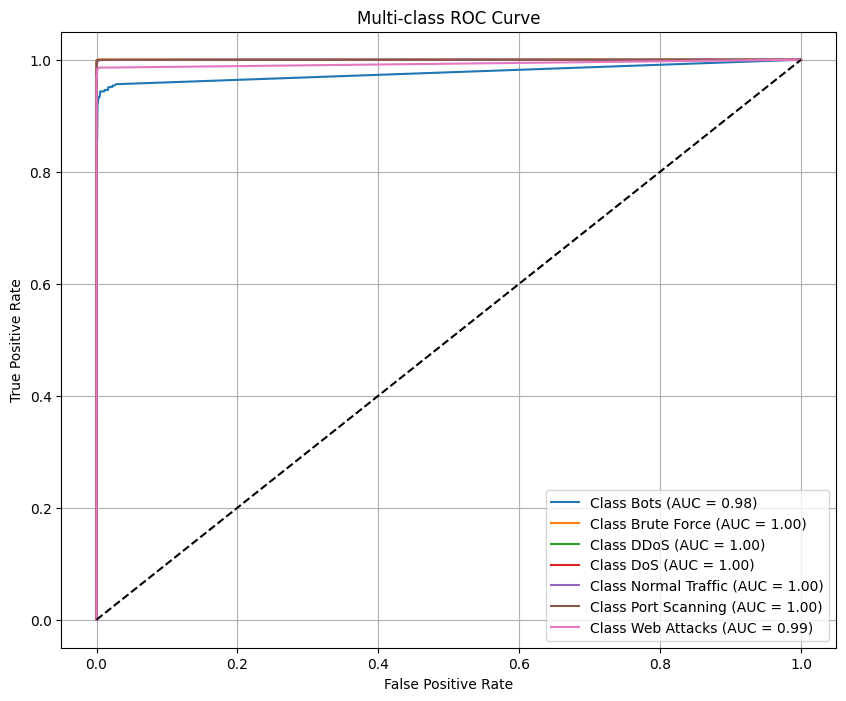

In [52]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_probs = best_rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10,8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### LIME Explanation

In [53]:
pip install lime


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  
    feature_names=feature_names,   
    class_names=['Safe', 'Ransomware'],
    mode='classification'
)

print("LIME explainer saved to explainer.pkl")
# Choose an instance to explain (e.g., first test instance)
i = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=best_rf_model.predict_proba
)

# Show explanation in notebook
# Save explanation as HTML
with open('lime_explanation.html', 'w', encoding='utf-8') as f:
    f.write(exp.as_html())

print("LIME explanation saved to lime_explanation.html — open it in your browser.")

LIME explainer saved to explainer.pkl
LIME explanation saved to lime_explanation.html — open it in your browser.


### Feature Importance

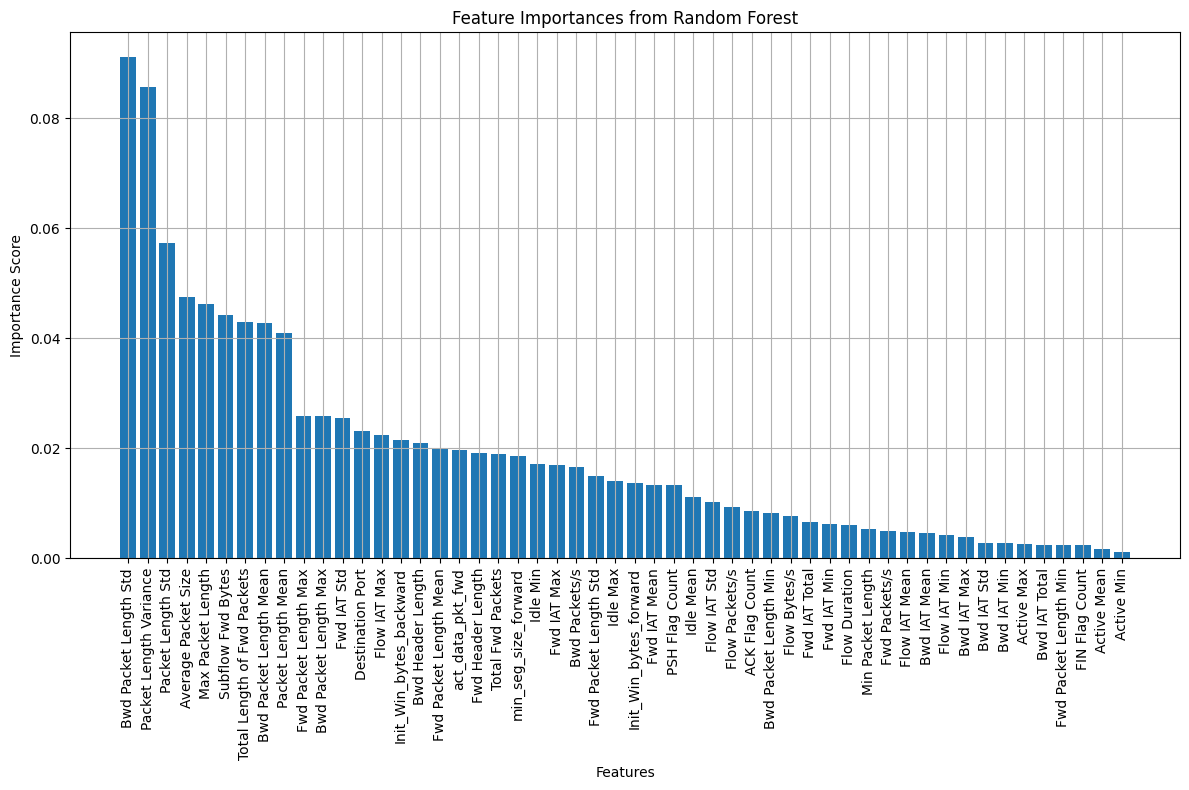

In [55]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances from Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()


# Compute the confusion matrix

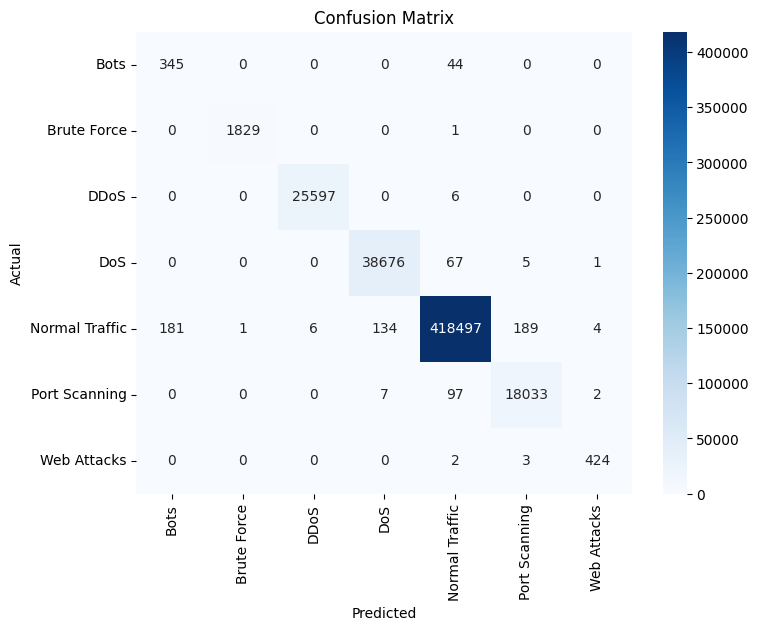

In [56]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


## 3. Integrate with Security Infrastructure Alerts & Logging:

In [57]:
import logging

logging.basicConfig(
    filename='security_alerts.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s'
)


### Adversarial Testing Simulation

In [58]:
import numpy as np

# Function to create adversarial samples by adding small noise
def generate_adversarial_examples(X, epsilon=0.05):
    X_adv = X.copy()
    noise = np.random.normal(0, epsilon, X.shape)
    X_adv = X_adv + noise
    return X_adv

# Generate adversarial test samples
X_test_adv = generate_adversarial_examples(X_test)

# Predict on adversarial samples
y_pred_adv = best_rf_model.predict(X_test_adv)

# Evaluate performance
from sklearn.metrics import accuracy_score

adv_accuracy = accuracy_score(y_test, y_pred_adv)
print(f"Accuracy on Adversarial Samples: {adv_accuracy:.4f}")


Accuracy on Adversarial Samples: 0.9982


## Creating email alert function

In [59]:
import smtplib
from email.mime.text import MIMEText

def send_email_alert(subject, message, smtp_server, smtp_port, sender_email, receiver_email, login, password):
    msg = MIMEText(message)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email
    
    try:
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()  # Upgrade to secure connection
            server.login(login, password)
            server.sendmail(sender_email, [receiver_email], msg.as_string())
        logging.info("Email alert sent successfully.")
    except Exception as e:
        logging.error(f"Error sending email alert: {e}")


# Creating a Function to Send Alerts to a SIEM

In [60]:
import requests
import json
from datetime import datetime

def send_to_siem(data, siem_url):
    headers = {'Content-Type': 'application/json'}
    try:
        response = requests.post(siem_url, data=json.dumps(data), headers=headers)
        if response.status_code == 200:
            logging.info("Data sent to SIEM successfully.")
        else:
            logging.error(f"Failed to send data to SIEM, status code: {response.status_code}")
    except Exception as e:
        logging.error(f"Error sending data to SIEM: {e}")


# Creating a Function to Block an IP via Firewall Integration

In [61]:
def block_ip(ip_address, firewall_api_url, api_key):
    payload = {
        "ip": ip_address,
        "action": "block",
        "reason": "Detected malicious activity"
    }
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json'
    }
    try:
        response = requests.post(firewall_api_url, data=json.dumps(payload), headers=headers)
        if response.status_code == 200:
            logging.info(f"IP {ip_address} blocked successfully.")
        else:
            logging.error(f"Failed to block IP {ip_address}. Status code: {response.status_code}")
    except Exception as e:
        logging.error(f"Error blocking IP {ip_address}: {e}")


# Processing  a Flow’s Prediction and Integrate with Security Infrastructure

In [62]:
def process_flow_alert(flow_data, prediction):

    malicious_labels = {"Bots", "Brute Force", "DDoS", "DoS", "Port Scanning", "Web Attacks"}
    
    if prediction in malicious_labels:
        alert_message = f"Malicious traffic detected: {prediction}. Flow details: {flow_data}"
        logging.info(alert_message)
      
        subject = f"Security Alert: {prediction} detected"
        send_email_alert(
            subject,
            alert_message,
            smtp_server="smtp.example.com", 
            smtp_port=587,
            sender_email="alert@example.com",  
            receiver_email="security_team@example.com",  
            login="alert@example.com", 
            password="yourpassword" 
        )
        siem_data = {
            "timestamp": datetime.utcnow().isoformat(),
            "alert": prediction,
            "flow": flow_data
        }
        send_to_siem(siem_data, siem_url="https://siem.example.com/ingest") 
        
        if "Source IP" in flow_data:
            block_ip(
                flow_data["Source IP"],
                firewall_api_url="https://firewall.example.com/api/block",
                api_key="your_api_key" 
            )
    else:
        logging.info(f"Normal traffic processed: {flow_data}")


## 4. Model Maintenance

In [63]:
import joblib

joblib.dump(model, "ransomware_detector_v2.joblib")
joblib.dump(scaler, "scaler_v2.joblib")


['scaler_v2.joblib']

In [64]:
model = joblib.load("ransomware_detector_v2.joblib")
scaler = joblib.load("scaler_v2.joblib")


## Cross Validatation to Model

In [65]:
data = pd.read_csv("ransomware_data.csv", sep=",")

X = data.drop("Attack Type", axis=1)
y = data["Attack Type"]

In [66]:
print(X.dtypes)

Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Length of Fwd Packets      int64
Fwd Packet Length Max            int64
Fwd Packet Length Min            int64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
Bwd Packet Length Max            int64
Bwd Packet Length Min            int64
Bwd Packet Length Mean         float64
Bwd Packet Length Std          float64
Flow Bytes/s                   float64
Flow Packets/s                 float64
Flow IAT Mean                  float64
Flow IAT Std                   float64
Flow IAT Max                     int64
Flow IAT Min                     int64
Fwd IAT Total                    int64
Fwd IAT Mean                   float64
Fwd IAT Std                    float64
Fwd IAT Max                      int64
Fwd IAT Min                      int64
Bwd IAT Total                    int64
Bwd IAT Mean                   float64
Bwd IAT Std              

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

scores = cross_val_score(rf, X, y, cv=skf, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy: {:.2f}%".format(np.mean(scores) * 100))
print("Std dev of CV accuracy: {:.2f}%".format(np.std(scores) * 100))


Cross-validation accuracy scores: [0.99859169 0.99860161 0.99851433 0.99854408 0.9985064 ]
Mean CV accuracy: 99.86%
Std dev of CV accuracy: 0.00%


### K-Fold Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy')

# Output mean and std deviation of CV accuracy
print(f"5-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


5-Fold CV Accuracy: 0.9986 ± 0.0000


## Double‐Check for Data Leakage

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)   
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Save all objects into a single pickle file

In [70]:
import pickle

data_to_save = {
    'model': best_rf,
    'scaler': scaler,

}

with open('all_objects.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("All objects saved in all_objects.pkl!")


All objects saved in all_objects.pkl!


In [71]:
import pickle

with open('all_objects.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

model = loaded_data['model']
scaler = loaded_data['scaler']

print("Objects loaded successfully!")


Objects loaded successfully!


In [72]:
!pip install --quiet pandas numpy scikit-learn imblearn lime matplotlib seaborn \
                   tensorflow==2.16.1 flask gunicorn joblib:
!pip install --quiet foolbox


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: 'joblib:': Expected end or semicolon (after name and no valid version specifier)
    joblib:
          ^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from joblib import dump, load

def load_dataset(path: str) -> pd.DataFrame:
    df = (ransomware_data_sample.csv)
    return df

def build_preprocess_pipeline(df: pd.DataFrame) -> tuple[Pipeline, LabelEncoder]:
    # encode target
    le = LabelEncoder()
    df['Attack Type Enc'] = le.fit_transform(df['Attack Type'])

    # identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Attack Type Enc')

    # column‑wise transformations
    numeric_transform = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transform, numeric_cols)],
        remainder="drop"
    )

    # full pipeline inc. SMOTE
    full_pipeline = Pipeline(steps=[
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=42, k_neighbors=2))
    ])
    return full_pipeline, le


In [74]:
import os
print(os.path.isfile("ransomware_data_sample.csv")) 


True


In [75]:
import pandas as pd                        # make sure this import is run

def load_dataset(path: str) -> pd.DataFrame:
    """
    Read *path* as a CSV and return a DataFrame.
    """
    return pd.read_csv(path)


In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

df = load_dataset("ransomware_data_sample.csv")
pipeline, label_enc = build_preprocess_pipeline(df)

X = df.drop(columns=["Attack Type", "Attack Type Enc"])
y = df["Attack Type Enc"]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [77]:
import numpy as np

# All numeric predictors (drop the raw + encoded target columns)
numeric_cols = (
    df.drop(columns=['Attack Type', 'Attack Type Enc'])   # remove targets
      .select_dtypes(include=[np.number])                 # keep only numbers
      .columns
      .tolist()
)

print(f"{len(numeric_cols)} numeric columns found:", numeric_cols[:8], "...")


52 numeric columns found: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std'] ...


In [78]:
import joblib

# Save trained Random Forest model
joblib.dump(model, 'random_forest_model.pkl')

print("Model saved successfully as random_forest_model.pkl")


Model saved successfully as random_forest_model.pkl


In [80]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Function to load saved model
def load_model(model_path):
    return joblib.load(model_path)

# Function to predict based on input data
def predict(data, model):
    prediction = model.predict([data])
    return prediction[0]

# Initialize Flask app
app = Flask(__name__)

# Prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json(force=True)
        features = data['features']

        prediction = model.predict([features])
        return jsonify({'prediction': prediction.tolist()})

    except Exception as e:
        return jsonify({'error': str(e)})


# Run the app
from threading import Thread

def run_app():
    app.run(debug=True, use_reloader=False)

# Run Flask app in a separate thread
flask_thread = Thread(target=run_app)
flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [91]:
pip install streamlit


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 3.0 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/9.8 MB 3.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.8 MB 1.9 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/9.8 MB 1.5 MB/s eta 0:00:06
   ------- -------------------------------- 1.8/9.8 MB 1.8 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.8 MB 2.0 MB/s eta 0:00:04
   ------------ --------------------------- 3.1/9.8 MB 2.2 MB/s eta 0:00:04
   ------------- -------------------------- 3.4/9.8 MB 2.3 MB/s eta 0:00:03
   -------------- ------------------------- 3.7/9.8 MB 2.0 MB/s eta 0:00:04
   ---------------- ----------------------- 3.9/9.8 MB 2.0 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.8 MB 1.9 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.8 MB 1.9 MB/s eta 0:00:03
   ----------------


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
